<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/DataSciUnit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install and import datasets and preliz libraries
!pip install datasets
from datasets import load_dataset

!pip install preliz
import preliz as pz

!pip install numpyro
import numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 9.6 MB/s eta 0:00:00
   ━━

In [ ]:
#Import other libraries
import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import random as rd
from matplotlib import pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.interpolate import PchipInterpolator
import pytensor.tensor as pt

In the game Super Mario Maker 2, players design their own Mario levels and share them online for others to play. Each level has a "clear rate," the proportion of level attempts that are successful. Each level is also given its own difficulty value by the game as categorized below. My goal is to predict difficulty as determined by clear rate.

In [ ]:
difficulties = {
    0: "Easy",
    1: "Normal",
    2: "Expert",
    3: "Super expert"
}

The Mario Maker 2 data used for this project was acquired from https://huggingface.co/datasets/TheGreatRambler/mm2_level. The dataset contains a variety of information about player uploaded levels, including the clear rates and difficulties.

The dataset is too large to load quickly in its entirety, so it is loaded in streaming mode, which means only part of the dataset is loaded at a time. 1000 entries of level data are acquired and shuffled, before the clear rate and difficulty of each level is recorded in a dictionary. The dictionary is then converted to a pandas dataframe.

The random seed used for acquiring the data was generated from Random.org's random integer generator from 1 to 100 (both inclusive) at 2024-12-05 18:54:57 UTC

In [ ]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=75)
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a dictionary to hold difficulties anc clear rate
level_data_dict = {"difficulty": [], "clear_rate": []}
#For each element of the list, record the relevant level data
for i in range(0, 1000):
  level_data_dict["difficulty"].append(sample[i]["difficulty"])
  level_data_dict["clear_rate"].append(sample[i]["clear_rate"])
#Convert the dictionary to a pandas dataframe
level_data_df = pd.DataFrame(level_data_dict)
#Convert difficulty to a category
level_data_df["difficulty"] = level_data_df["difficulty"].astype('category')
#Display the dataframe
level_data_df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/5.51k [00:00<?, ?B/s]

,difficulty,clear_rate
0,1,14.814815
1,1,26.108374
2,1,9.090909
3,0,81.218274
4,0,77.611940
...,...,...
995,1,22.872340
996,0,56.716418
997,1,23.529412
998,0,33.333333


In [ ]:
#numpy array of difficulty number codes
difficulty_codes = pd.Categorical(level_data_df["difficulty"]).codes
print(difficulty_codes)

#makes a numpy array of the clear rate values
clear_rate_arr = level_data_df.clear_rate.values
print(clear_rate_arr)

[1 1 1 0 0 1 0 3 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 2 1 1 2 1 0 2 1 0 0 0 0 2 0
 2 0 0 1 2 1 1 2 1 1 3 1 2 2 2 1 1 3 0 0 3 1 0 1 2 1 0 0 3 2 1 1 2 1 1 0 0
 2 1 1 0 1 2 0 0 1 3 3 1 1 2 0 2 1 0 0 0 1 0 0 0 3 3 1 0 0 1 1 1 1 1 1 0 0
 1 2 1 1 2 0 1 0 1 1 1 1 1 1 0 1 2 3 0 2 0 1 0 1 0 1 1 2 3 2 1 0 0 1 0 1 1
 0 3 0 0 2 0 1 3 2 1 0 0 1 1 2 1 0 0 1 1 0 1 1 1 2 0 3 1 0 1 1 1 1 2 0 3 1
 1 0 0 3 0 2 1 2 0 2 3 1 0 0 0 1 0 0 1 1 1 3 1 1 1 0 1 1 1 1 1 1 2 1 0 1 3
 0 0 1 2 0 1 1 0 3 1 2 0 1 2 1 1 0 2 2 0 1 1 1 1 1 3 0 1 2 1 0 0 1 0 1 0 0
 0 2 1 0 1 0 0 1 0 3 1 0 1 1 2 0 0 1 0 0 1 1 1 2 0 1 2 0 1 1 0 1 1 1 1 1 1
 0 2 1 1 2 0 0 0 1 0 0 1 3 1 0 2 1 2 1 1 2 3 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1
 0 0 0 2 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 2 0 1 1 1 2 3 2 0 0 1 0 0 1 0 1
 2 2 0 2 1 2 3 0 1 0 1 0 1 2 1 0 0 2 1 1 0 1 3 1 0 2 1 1 0 0 1 0 1 0 2 0 1
 1 2 1 1 2 3 2 1 0 1 1 3 3 0 1 0 0 0 1 1 0 1 2 0 2 0 0 1 1 1 1 0 1 1 0 0 3
 1 1 0 1 2 1 0 1 0 0 1 0 0 1 1 1 1 0 2 0 0 1 1 0 2 0 3 1 1 1 2 1 0 1 3 2 0
 1 2 1 0 0 0 0 1 1 3 1 2 

Difficulty by clear rate among the observed level data is plotted below. In the next cell, the counts of each difficulty type are printed. There are far more easy and normal levels than expert or super expert ones.

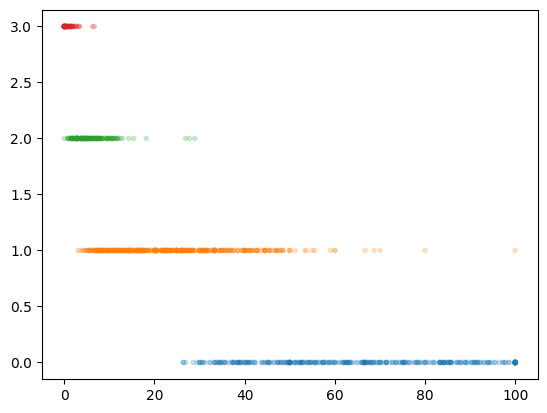

In [ ]:
#plots different difficulties in different colors
#Darker dots means more points are there
plt.scatter(clear_rate_arr, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

In [ ]:
#Plot the count of levels of each difficulty
print("Difficulty: Count")
for i in range(0, 4):
  print(str(i) + ": " + str(level_data_df["difficulty"].value_counts().get(i, 0)))

Difficulty: Count
0: 342
1: 441
2: 154
3: 63


I will use a logistic regression for multiple categories to predict difficulty. The prior for the cutpoints between difficulty ratings uses a constrained dirichlet distribution. The mean line is transformed through the log function.

In [ ]:
#Function to specify a prior over the cutpoints in the predicted variable by Dr. Ben Vincent and Adrian Seyboldt
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min) + min,
            ]
        ),
    )

In [ ]:
with pm.Model() as difficulty_model_log:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_log = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_log.extend(pm.sample_posterior_predictive(idata_difficulty_log))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
ERROR:pymc.stats.convergence:There were 758 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [ ]:
#Print alpha, beta, and the cutpoints
az.summary(idata_difficulty_log, var_names=["cutpoints", "α", "β"])

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
cutpoints[1],2.321,0.076,2.182,2.453,0.005,0.004,212.0,282.0,1.01
cutpoints[2],4.000,0.000,4.000,4.000,0.000,0.000,2010.0,2000.0,1.00
α,3.982,0.272,3.492,4.497,0.020,0.015,180.0,150.0,1.01
β[0],-0.040,0.003,-0.045,-0.035,0.000,0.000,179.0,151.0,1.01


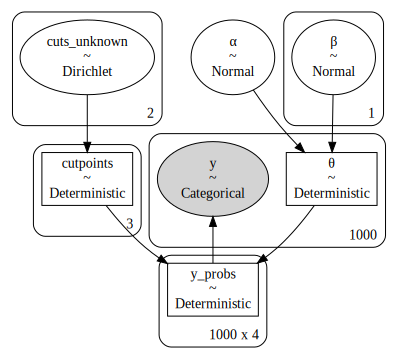

In [ ]:
#Visualize the model hierarchy
pm.model_to_graphviz(difficulty_model_log)

Below, we can visualize the difficulty prediction of a certain level from the data based on its clear rate. The probability of each difficulty by intervals plotted.

In [ ]:
implied_probs = az.extract(idata_difficulty_log, var_names=["y_probs"])
implied_probs.shape

(1000, 4, 2000)

In [ ]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 4)> Size: 32B
array([0.2286375 , 0.52189447, 0.19112903, 0.058339  ])
Coordinates:
    y_probs_dim_0  int64 8B 0
  * y_probs_dim_1  (y_probs_dim_1) int64 32B 0 1 2 3

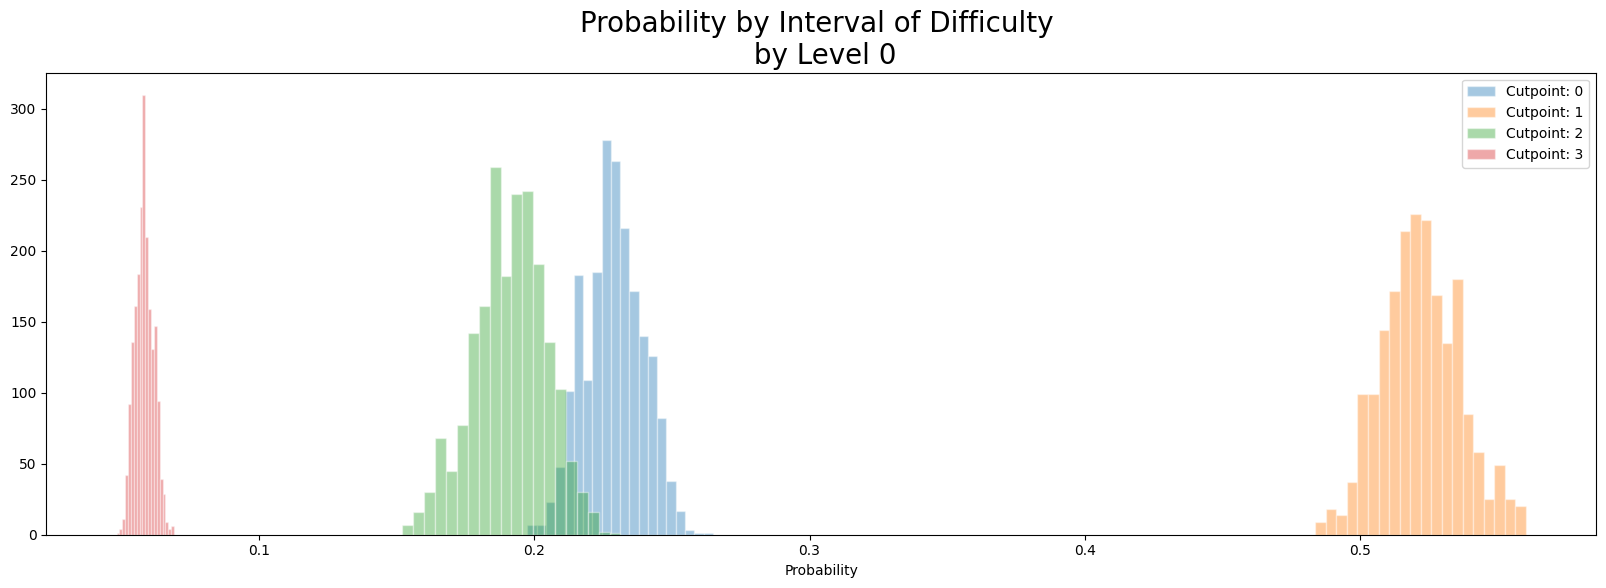

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(len(level_data_df["difficulty"].unique())):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20, alpha=0.4)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Difficulty \n by Level 0", fontsize=20)
ax.legend();

We can also plot the regression line and cutpoints on the difficulty by clear rate graph. The cutpoints, interestingly, appear to be unreasonable values, yet the model is very certain about them. The cutpoint between easy and normal has a mean at zero, and the 3% and 97% HDI values are zero as well. The cutpoint between normal and expert has a mean of about 2.4. The cutpoint between expert and super expert has a mean of four, which matches its 3% and 97% HDI values. I had originally thought a good mean line would have a shape similar to the apparent exponential-like shape of the data, but, unexpectedly, the model that worked best was the log model.

In [ ]:
def PlotLine(idata):
  #grab the posterior
  posterior = idata.posterior
  mu = posterior["θ"].mean(("chain", "draw"))

  #this will help us tanslate from the standardized data back to the raw data
  idx = np.argsort(clear_rate_arr)

  #set up the plot
  _, ax = plt.subplots(figsize=(12, 6))

  #plot the posterior
  ax.plot(clear_rate_arr[idx], mu[idx], color="C0", lw=2)
  ax.hlines(posterior["cutpoints"].mean(("chain", "draw")), 0, 100, color="C2", zorder=0)

  #Plot cutpoints
  cutpoints_hdi = az.hdi(posterior["cutpoints"])
  for i in range(0, len(cutpoints_hdi["cutpoints"])):
    ax.fill_between([0, 100], cutpoints_hdi["cutpoints"][i][0], cutpoints_hdi["cutpoints"][i][1], color="C2", alpha=0.6, lw=0)

  #scatter plot of raw data
  ax.scatter(clear_rate_arr, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

  #plots the sigmoid regression
  az.plot_hdi(clear_rate_arr, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})

  #labels
  ax.set_xlabel('clear rate')
  ax.set_ylabel("θ", rotation=0)

  # use original scale for xticks
  locs, _ = plt.xticks()

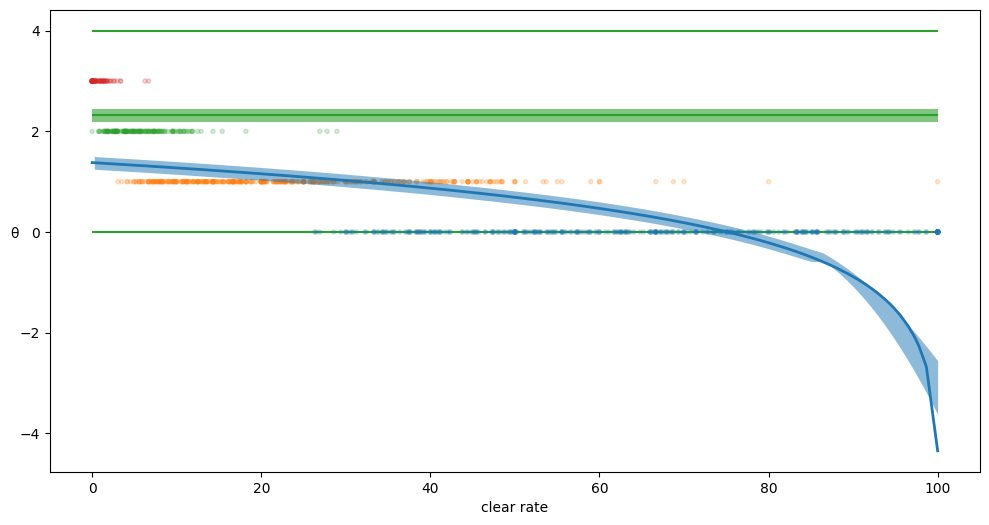

In [ ]:
PlotLine(idata_difficulty_log)

To check the predictive goodness of fit, a posterior predictive check is plotted alongside a plot how each of clear rate data point is predicted to fall on the difficulty scale. The difficulty predictions of the latter graph match the true difficulty counts very well. The posterior predictive check, despite the seemingly nonsensical cutpoints and strange mean line shape, indicates the model's predictions have a mean reasonably close to the observed data. Some confidence can thus be placed in this model, though the variance of predictions off of the mean line is not small.
Ultimately, the tendency of this model towards categorizing levels as normal makes sense in the context that more of those levels exist than any other difficulty. The goodness of fit checks show the model fits relatively well, despite the unexpected posterior distribution.

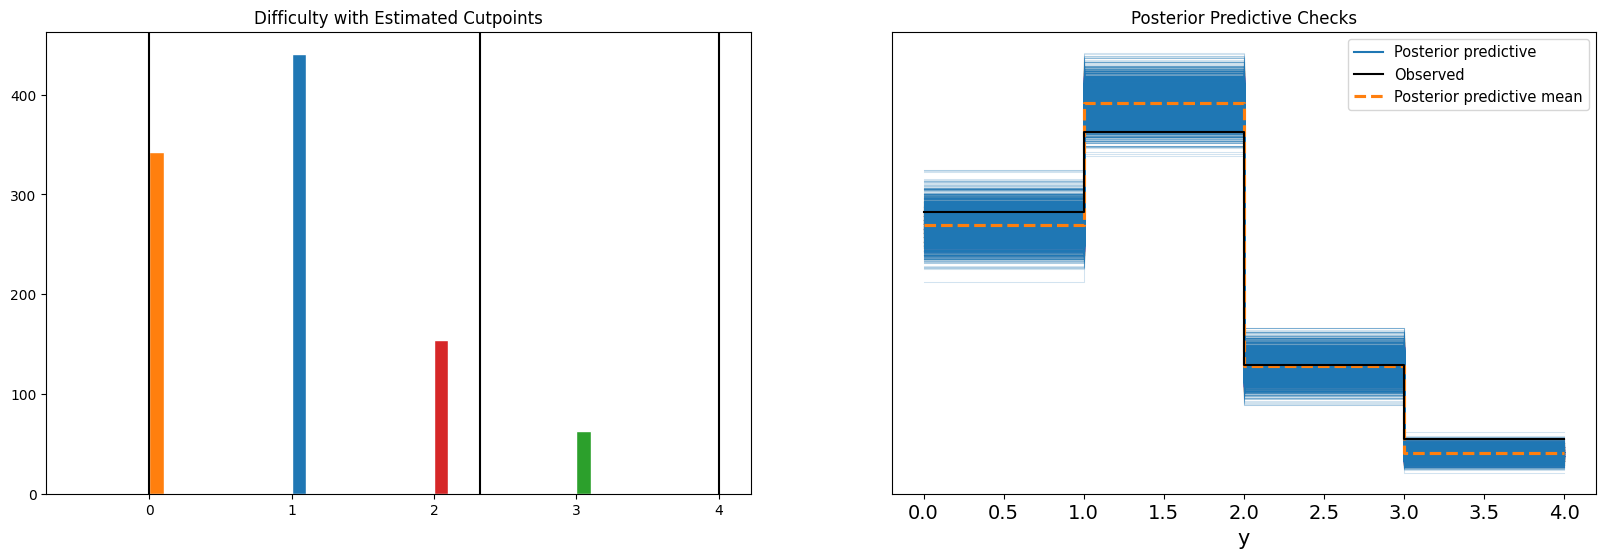

In [ ]:
def plot_fit(idata):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs = axs.flatten()
    ax = axs[0]
    for i in range(4 - 1):
        ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
    for r in level_data_df["difficulty"].unique():
        temp = level_data_df[level_data_df["difficulty"] == r]
        ax.hist(temp["difficulty"], ec="white")
    ax.set_title("Difficulty with Estimated Cutpoints")
    axs[1].set_title("Posterior Predictive Checks")
    az.plot_ppc(idata, ax=axs[1])
    plt.show()

plot_fit(idata_difficulty_log)

In [ ]:
def PlotTwo(idata):
  #Get posterior
  posterior = idata.posterior
  mu = posterior["θ"].mean(("chain", "draw"))

  #this will help us tanslate from the standardized data back to the raw data
  idx = np.argsort(clear_rate_arr)

  #set up the plot
  fig, axs = plt.subplots(1, 2, figsize=(20, 6))
  axs = axs.flatten()
  ax = axs[0]

  #plot the posterior
  ax.plot(clear_rate_arr[idx], mu[idx], color="C0", lw=2)
  ax.hlines(posterior["cutpoints"].mean(("chain", "draw")), 0, 100, color="C2", zorder=0)

  #Plot cutpoints
  cutpoints_hdi = az.hdi(posterior["cutpoints"])
  for i in range(0, len(cutpoints_hdi["cutpoints"])):
    ax.fill_between([0, 100], cutpoints_hdi["cutpoints"][i][0], cutpoints_hdi["cutpoints"][i][1], color="C2", alpha=0.6, lw=0)

  #scatter plot of raw data
  ax.scatter(clear_rate_arr, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

  #plots the sigmoid regression
  az.plot_hdi(clear_rate_arr, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})

  #labels
  ax.set_xlabel('clear rate')
  ax.set_ylabel("θ", rotation=0)

  # use original scale for xticks
  locs, fig = plt.xticks()

  ax.set_title("Posterior")
  axs[1].set_title("Posterior Predictive Checks")
  az.plot_ppc(idata, ax=axs[1])
  plt.show()


# Further Models

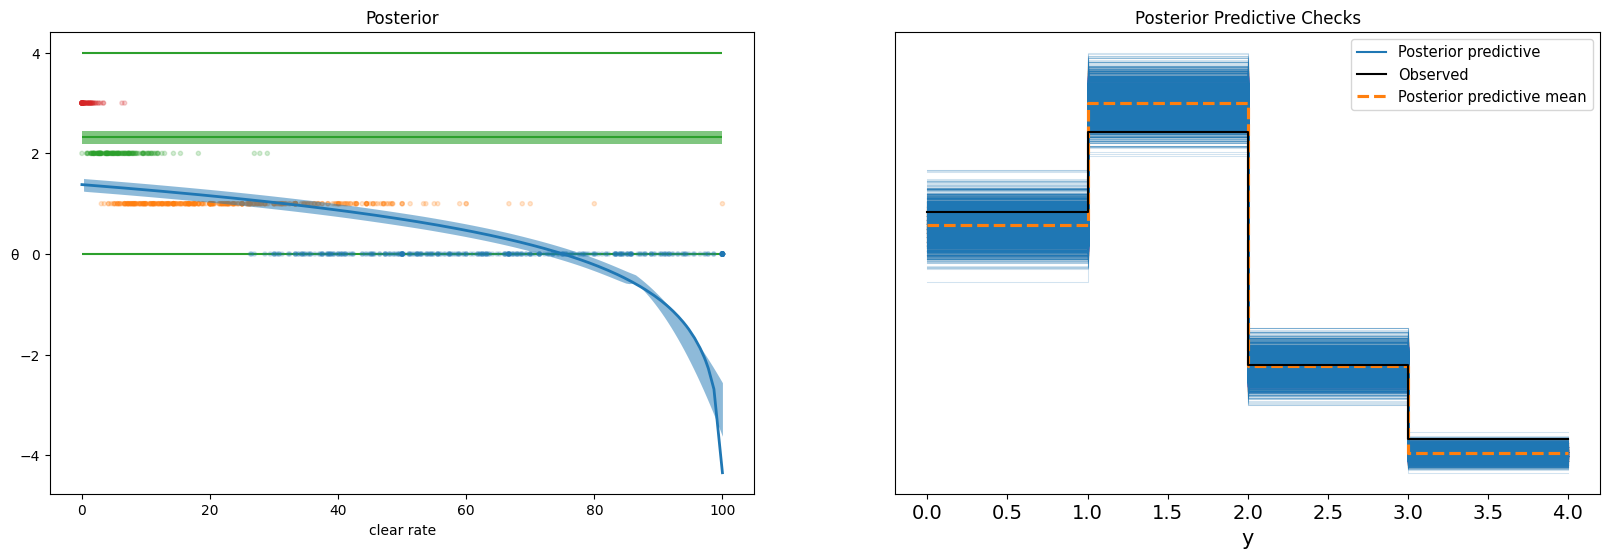

In [ ]:
PlotTwo(idata_difficulty_log)

In [ ]:
with pm.Model() as difficulty_model_c:
    #Priors
    cutpoints_c = constrainedUniform(7, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints_c, eta=θ, observed=difficulty_codes)

    idata_difficulty_c = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_c.extend(pm.sample_posterior_predictive(idata_difficulty_c))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
ERROR:pymc.stats.convergence:There were 849 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [ ]:
#Print alpha, beta, and the cutpoints
az.summary(idata_difficulty_c, var_names=["cutpoints", "α", "β"])

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
cutpoints[1],1.953,0.075,1.817,2.089,0.004,0.002,455.0,451.0,1.00
cutpoints[2],3.043,0.083,2.888,3.203,0.004,0.003,490.0,423.0,1.01
cutpoints[3],3.961,0.030,3.904,3.999,0.002,0.002,125.0,236.0,1.03
cutpoints[4],3.980,0.021,3.941,4.000,0.001,0.001,100.0,68.0,1.02
cutpoints[5],4.000,0.000,4.000,4.000,0.000,0.000,1681.0,1498.0,1.00
α,3.211,0.220,2.814,3.633,0.013,0.009,300.0,342.0,1.01
β[0],-0.032,0.002,-0.036,-0.028,0.000,0.000,299.0,338.0,1.01


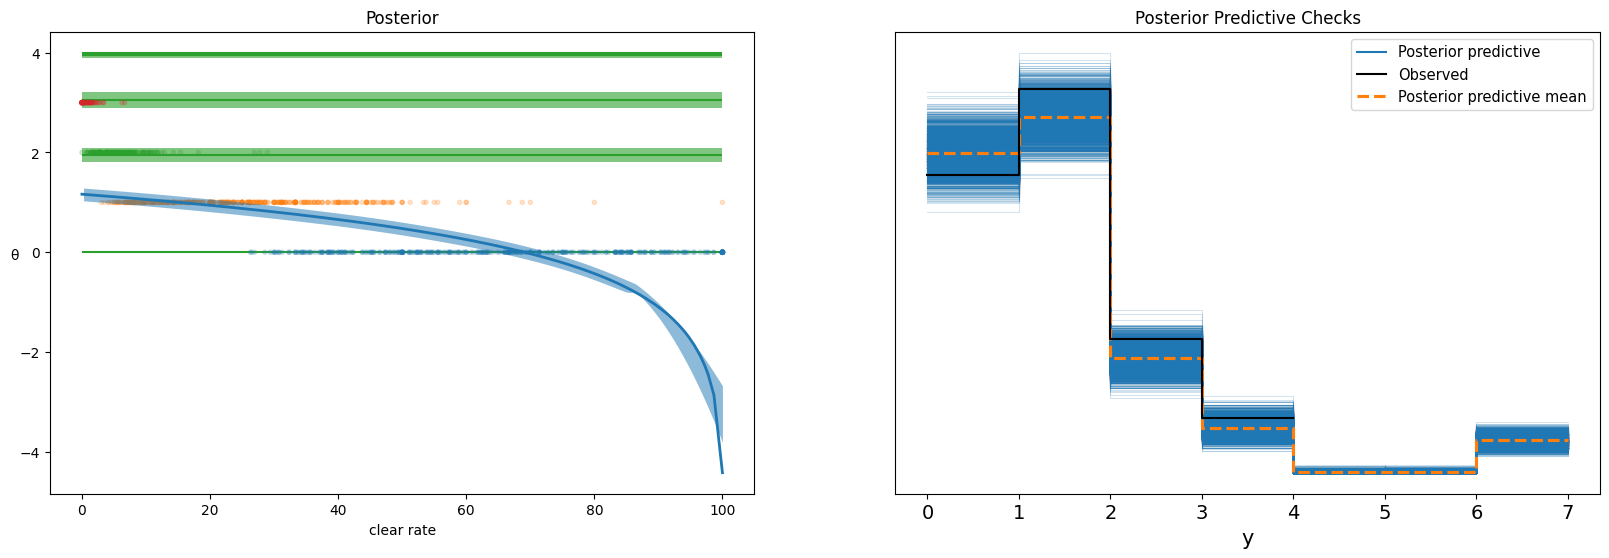

In [ ]:
PlotTwo(idata_difficulty_c)

In [ ]:
with pm.Model() as difficulty_model_exp:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_exp = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_exp.extend(pm.sample_posterior_predictive(idata_difficulty_exp))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

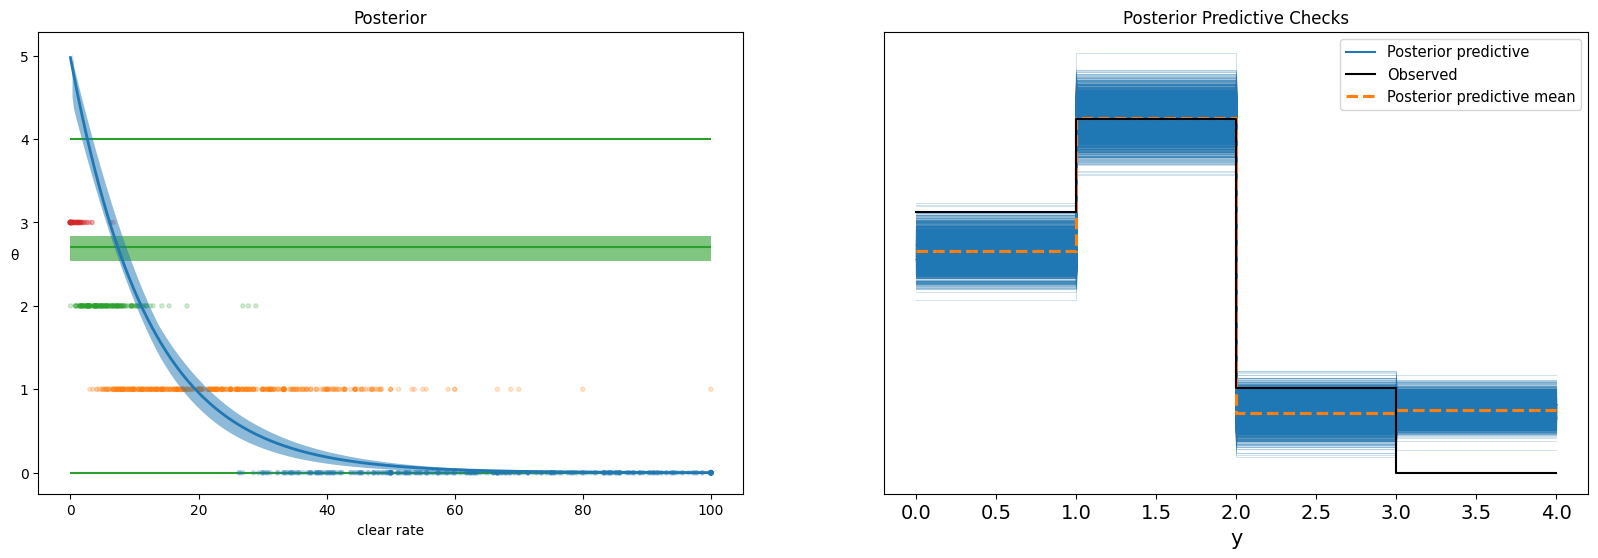

In [ ]:
PlotTwo(idata_difficulty_exp)

In [ ]:
with pm.Model() as difficulty_model_exp_c6:
    #Priors
    cutpoints = constrainedUniform(6, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_exp_c6 = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_exp_c6.extend(pm.sample_posterior_predictive(idata_difficulty_exp_c6))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

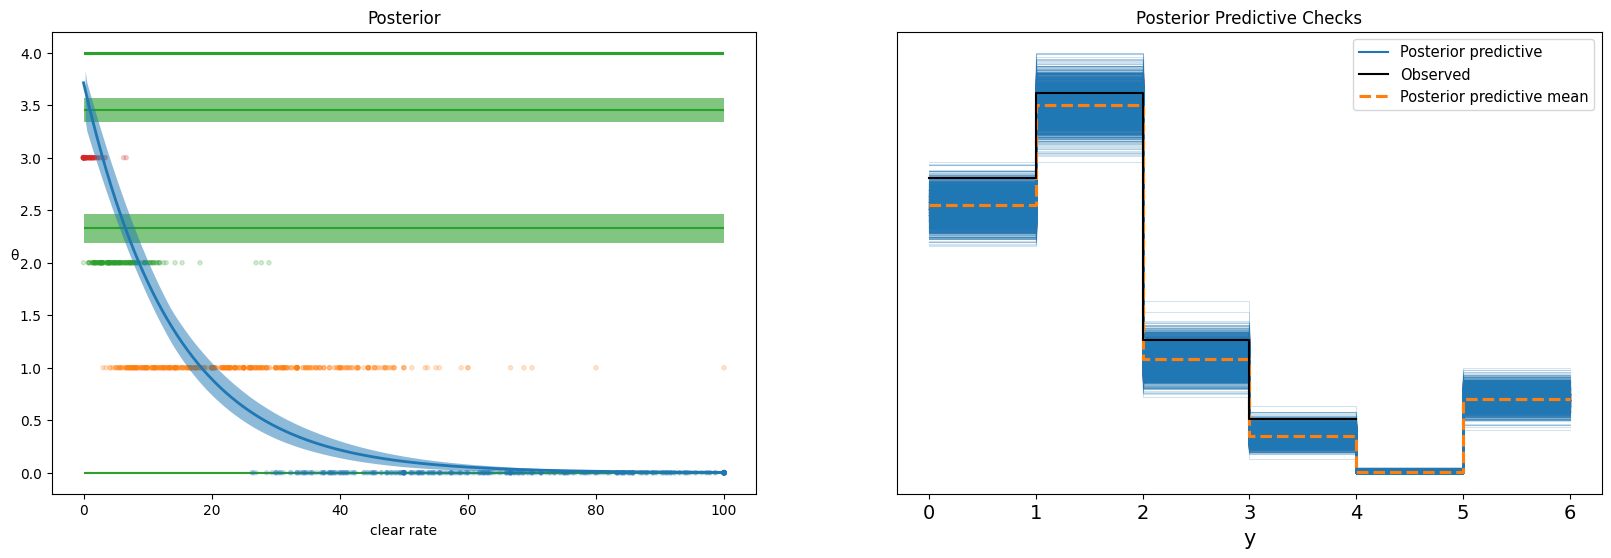

In [ ]:
PlotTwo(idata_difficulty_exp_c6)

In [ ]:
with pm.Model() as difficulty_model_exp_c7:
    #Priors
    cutpoints = constrainedUniform(7, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_exp_c7 = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_exp_c7.extend(pm.sample_posterior_predictive(idata_difficulty_exp_c7))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

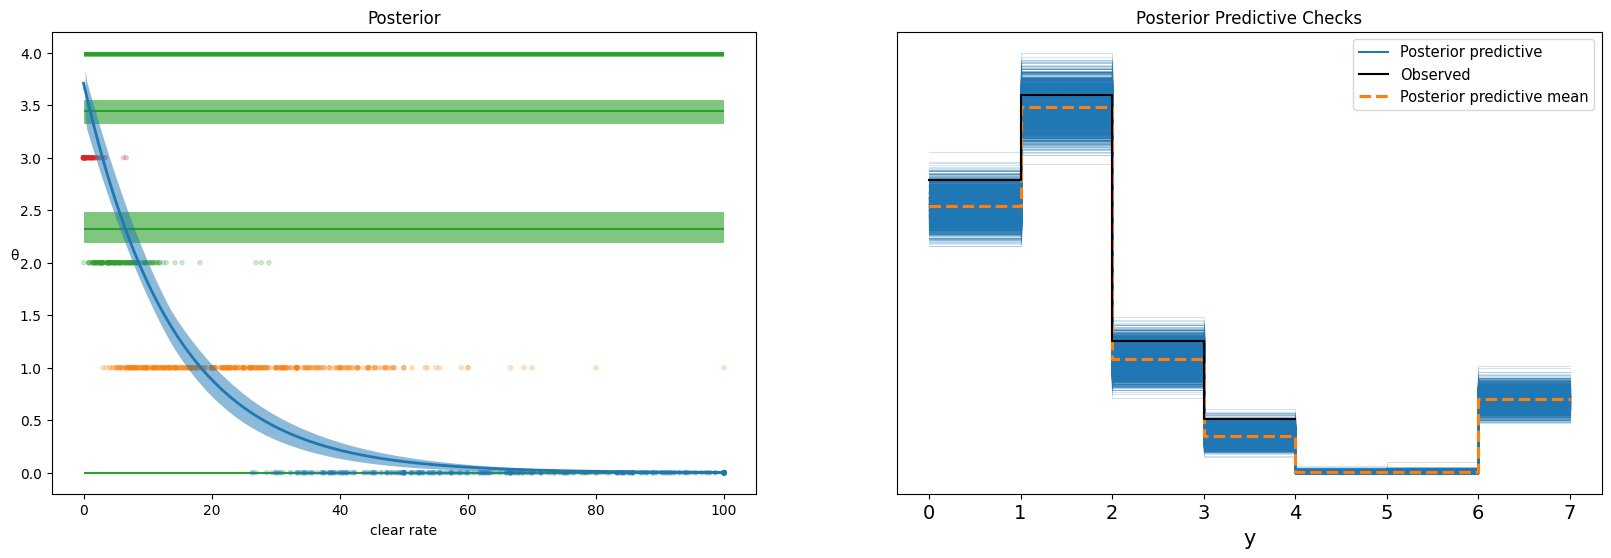

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
cutpoints[1],2.326,0.076,2.191,2.478,0.002,0.001,2026.0,1674.0,1.00
cutpoints[2],3.443,0.061,3.323,3.549,0.001,0.001,2059.0,1487.0,1.00
cutpoints[3],3.982,0.013,3.959,4.000,0.000,0.000,585.0,919.0,1.01
cutpoints[4],3.991,0.009,3.975,4.000,0.000,0.000,858.0,742.0,1.00
cutpoints[5],4.000,0.000,4.000,4.000,0.000,0.000,2101.0,1955.0,1.00
α,1.310,0.041,1.231,1.386,0.001,0.001,967.0,881.0,1.00
β[0],-0.072,0.005,-0.082,-0.062,0.000,0.000,1139.0,1301.0,1.00


In [ ]:
PlotTwo(idata_difficulty_exp_c7)

In [ ]:
with pm.Model() as difficulty_model_sig:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", 4 * pm.math.sigmoid(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_sig = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_sig.extend(pm.sample_posterior_predictive(idata_difficulty_sig))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

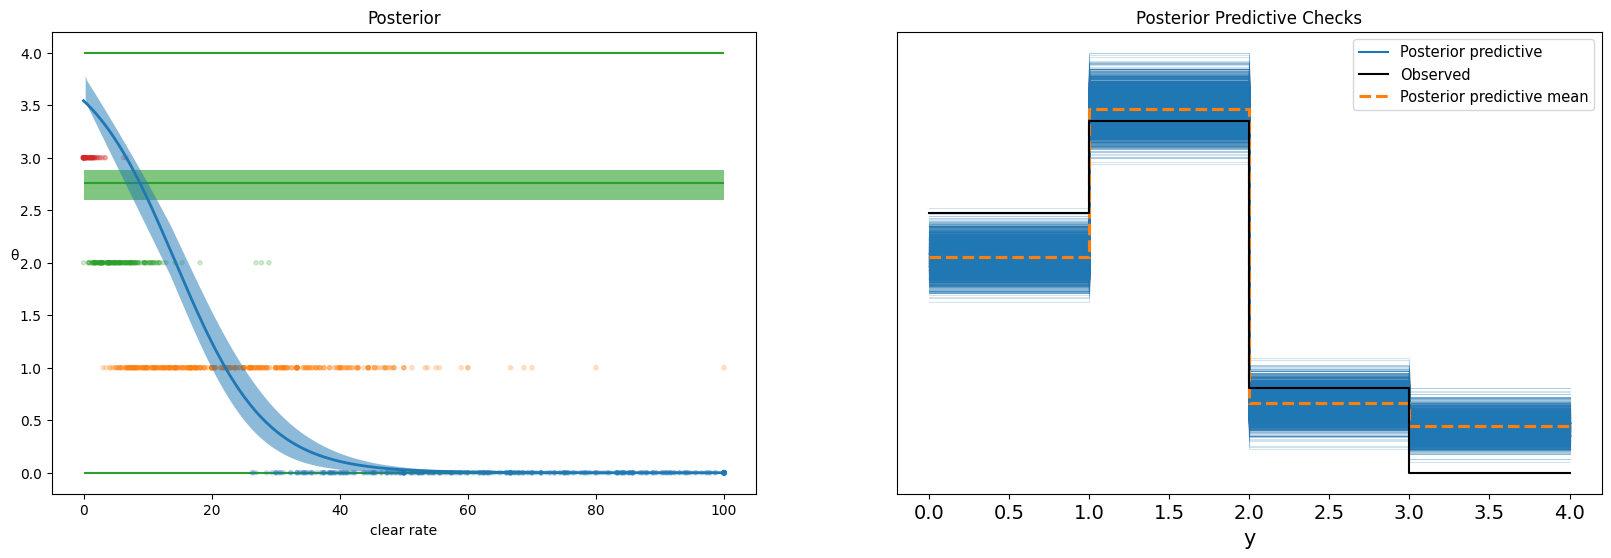

In [ ]:
PlotTwo(idata_difficulty_sig)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

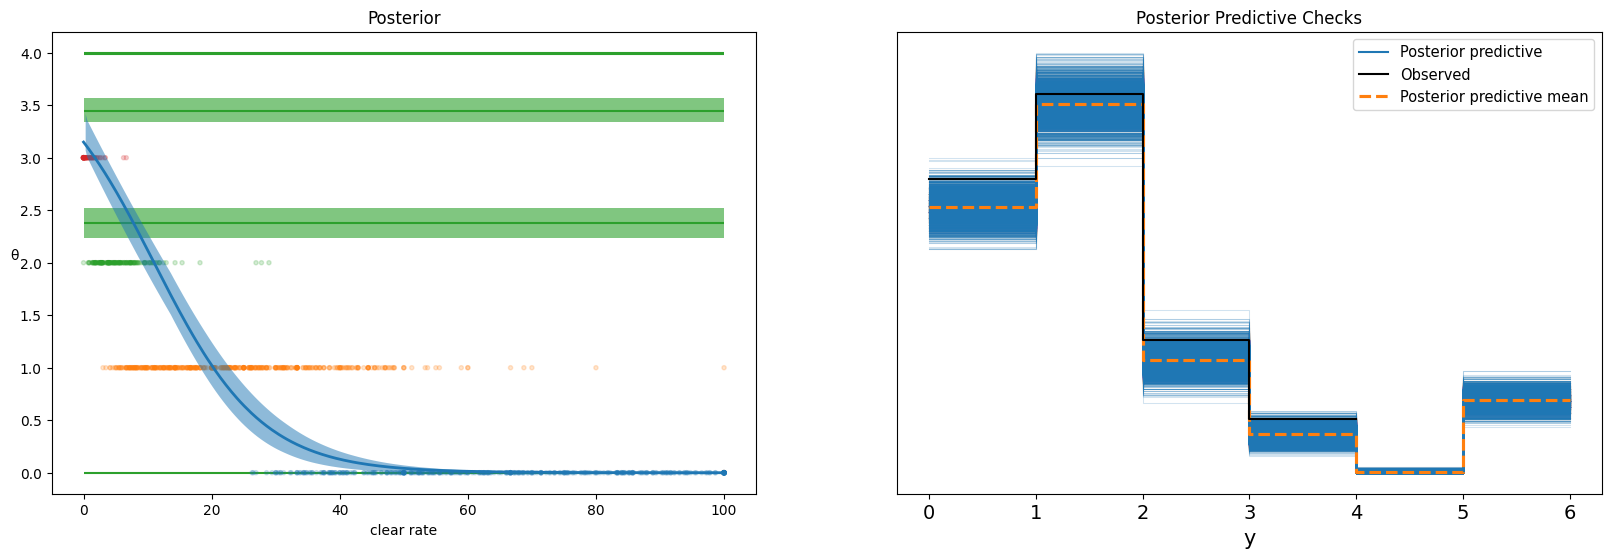

In [ ]:
with pm.Model() as difficulty_model_sig_c:
    #Priors
    cutpoints = constrainedUniform(6, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", 4 * pm.math.sigmoid(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_sig_c = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_sig_c.extend(pm.sample_posterior_predictive(idata_difficulty_sig_c))

PlotTwo(idata_difficulty_sig_c)

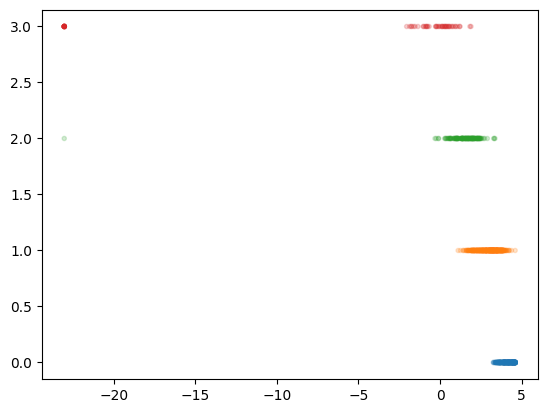

In [ ]:
#Log clear rate
clear_rate_log = np.zeros_like(clear_rate_arr).astype(float)
for i in range(0, len(clear_rate_log)):
  if clear_rate_arr[i] == 0:
    clear_rate_log[i] = np.log(0.0000000001)
  else:
    clear_rate_log[i] = np.log(clear_rate_arr[i])
plt.scatter(clear_rate_log, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

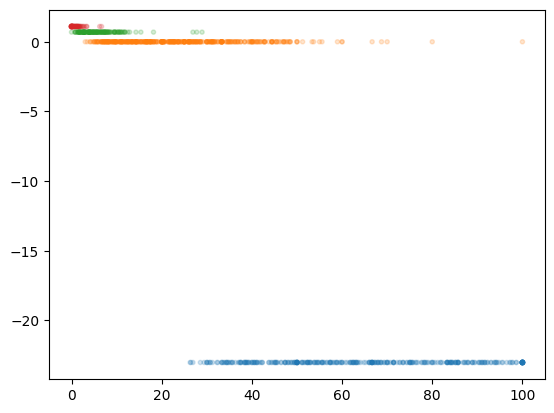

In [ ]:
#Log difficulty
difficulty_log = np.zeros_like(difficulty_codes).astype(float)
for i in range(0, len(difficulty_log)):
  if difficulty_codes[i] == 0:
    difficulty_log[i] = np.log(0.0000000001)
  else:
    difficulty_log[i] = np.log(difficulty_codes[i])
plt.scatter(clear_rate_arr, difficulty_log, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

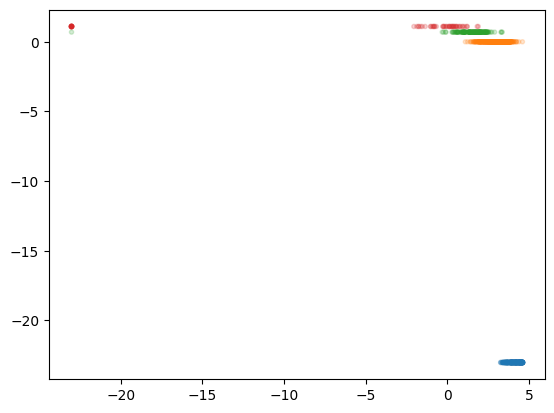

In [ ]:
#Log difficulty and clear rate
plt.scatter(clear_rate_log, difficulty_log, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

In [ ]:
with pm.Model() as difficulty_model_logdata:
    #Priors
    cutpoints = constrainedUniform(7, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * np.log(clear_rate_arr)
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_ld = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_ld.extend(pm.sample_posterior_predictive(idata_difficulty_ld))

<ipython-input-62-c466981c2ad3>:7: RuntimeWarning: divide by zero encountered in log
  μ = α + β[0] * np.log(clear_rate_arr)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'cuts_unknown_simplex__': array([ 0.74193099, -0.12535773, -0.11158717, -0.64730186]), 'α': array(0.72834996), 'β': array([-0.24552726])}

Logp initial evaluation results:
{'cuts_unknown': -3.78, 'α': -2.32, 'β': -0.95, 'y': -inf}
You can call `model.debug()` for more details.

In [ ]:
PlotLine(idata_difficulty_ld)